# CodeAssist
The CodeAssist Agent is designed to interupt user programming requests, generate Python code snippets, take feedback, produce test cases and run the generated code by simulating a test of the generated code.

**Instruction**: To run a custom task execute all the cells in order of the code block.

### Below are some key components of the design:

#### Agentic Framework:
- LlamaIndex Workflow is a very recently introduced library in python. Which is an event-driven abstraction used to chain together several events.
- Made up of @steps, with each step responsible for handling certain event types and emitting new elements.
-Asynchronous functions enable parallel execution of tasks, reducing response time and improving user experience.
#### Custom Event Handling:
- Several custom events( ModifiedEvent, TestCasesEvent, FeedbackEvent) are implemented to handle various stages of the assistant's workflow.
- Events are structured using asynchronous workflows to support seamless execution of multiple tasks concurrently.
#### Interactivity:
- The agent engages with the user throughout the process, asking for clarification, providing results, and prompting results, and prompting feedback or further instructions.
- It can handle iterative improvements based on user input, ensuring solutions evolve as tasks are clarified.
#### Error Handling:
- The testing phase incorporates retry mechanisms and error simulation to demostrate robustness.
- Errors are logged with clear messages to help debug issues and refine future interactions.

### Approach to the Design:
Initially, the design process focused on creating a simple and linear workflow:

1) Task Input: Accepting a programming task or question from the user.
2) Code Generation: Generating a Python code snippet based on the user’s task.
3) Testing and Running: Executing the generated code to validate its correctness.

This linear flow formed the foundation of the agent. However, as we iterated on the design, it became clear that real-world scenarios required additional functionality to handle edge cases, errors, and user interactivity. This led to the introduction of custom events and modular workflows.

Assumptions:
- Testing logic simulates outcomes (random success/failure) rather than executing real test cases.
- This mock implementation ensures the demonstration focuses on workflow clarity.
- The user is expected to provide clear feedback or clarifications when prompted.
- Inputs are assumed to be valid Python tasks or questions.

**ModifiedEvent():**
- Handles the refinement of the user’s task by rephrasing it into a clearer, actionable prompt.

**CodeEvent():**
- Generates concise and well-structured code that effectively addresses the user's task. Provides step-by-step explanations and outlines the approach taken by the CodeAssist agent in generating the code.

**TestCasesEvent():**
- Automates the generation of test cases for validating the generated code, simulating real-world scenarios and edge cases.

**FeedbackEvent():**
- Manages the feedback loop, allowing users to suggest refinements or report issues with the generated code, leading to iterative improvements.

**TestResultEvent():**
- Tests the generated code by simulating its execution. Includes a retry mechanism to handle failures or errors encountered during code execution.


This is an image of all the possible workflows of the agent CodeAssist:


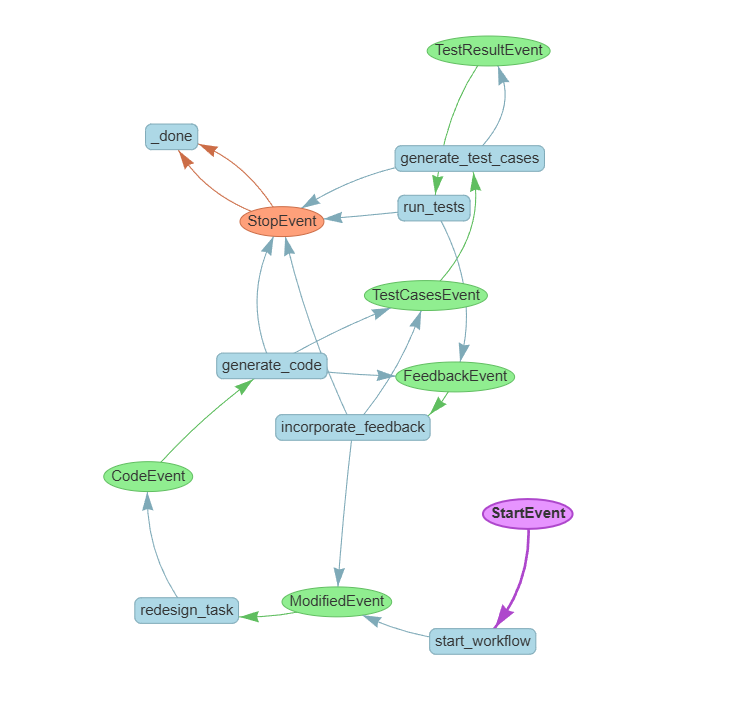

### Code:

In [1]:
import os
from typing import List, Dict, Tuple
import pytest
import tempfile
from llama_index.llms.groq import Groq
from llama_index.core.workflow import Event, StartEvent, StopEvent, Workflow, step
from llama_index.core.workflow import draw_all_possible_flows
from llama_index.utils.workflow import draw_most_recent_execution

In [2]:
groq_api_key = "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"

In [3]:
llm = Groq(
    api_key=groq_api_key,
    model="llama-3.3-70b-versatile"
)

In [4]:

# Define custom events
class ModifiedEvent(Event):
    task: str

class TestCasesEvent(Event):
    modified_task: str
    code: str
    # test_cases: List[Dict]

class CodeEvent(Event):
    modified_task: str

class TestResultEvent(Event):
    code: str
    test_cases: str

class FeedbackEvent(Event):
    feedback: str
    modified_task: str
    code: str

In [36]:
import random
from llama_index.core.workflow.context import Context


class CodingWorkflow(Workflow):
    
    @step
    async def start_workflow(self, ev: StartEvent) -> ModifiedEvent:
        llm = Groq(
            api_key=groq_api_key,
            model="llama-3.3-70b-versatile"
        )
        self.max_retries = 3
        task = ev.request  # Retrieve task from context
        
        print("========= Original Task ===========")
        print("Task:", task)
        print("===============================")
        return ModifiedEvent(task=task)


    @step
    async def redesign_task(self, ctx: Context, ev: ModifiedEvent) -> CodeEvent:
        task = ev.task
        prompt = f"""
        You are an AI assistant created to refine and simplify {task} provided by users, making them more readable and usable for code generation models, such as AI coding assistants like Copilot. Your task involves the following steps:
        Understand the User's Task:
        Comprehend the user's input and determine the primary objective of the task.
        Identify any important details, requirements, or constraints associated with the task.
        
        Refine and Simplify:
        Rewrite the task description in a way that is concise, well-structured, and easy to understand.
        Use terminology and formatting that aligns with common programming concepts to ensure it is clear for code generation models.
        Retain all critical details necessary for implementing the solution, while removing any redundant or overly complex language.
        
        Output the Refined Task:
        Provide the rewritten task in a format that is ready for a code generation assistant to interpret and use.
        If applicable, include examples, expected input/output formats, or additional context to make the task even clearer.
        
        Provide a clear and concise description of the task.
        DONT RETURN ANYTHING ELSE.
        """
        response = await llm.acomplete(prompt)
        print("========= Redesigned Task =========")
        print(response.text)
        print("===================================")
        
        # Store the modified task in global context
        await ctx.set("modified_task", response.text)

        # return TaskEvent(task=response.text)
        return CodeEvent(modified_task= response.text)
    
    
    
    @step
    async def generate_code(self, ev: CodeEvent) -> FeedbackEvent | TestCasesEvent | StopEvent:
        
        task = ev.modified_task  # Retrieve task from context        
        prompt = f"""Write Python code for the following task:
        {task}
        
        Write a function named 'solution' 
        First explain the approach stepwise in comments and then write then return the function only.
        DONT PREFIX THE CODE WITH ```python or any other code block.
        DIRECTLY RETURN THE FUNCTION IMPLEMENTATION.
        The function should contain one liner comments whereever necessary.
        """
        
        response = await llm.acomplete(prompt)
        print("========= Code Generation Response =========")
        print(response.text)
        print("============================================")
        
        # Take input from user and ask if he wants to give 1. feedback, or 2. produce test cases or 3. stop event
        choice = input("Do you want to give feedback or produce test cases or stop event? (feedback/test/stop): ")
        if choice == "feedback":
            feedback = input("Please provide feedback: ")
            return FeedbackEvent(feedback=feedback, modified_task=task, code = response.text)
        elif choice == "test":
            return TestCasesEvent(modified_task=task, code=response.text)
        else:
            return StopEvent(result="Success")       

    @step
    async def incorporate_feedback(self, ev: FeedbackEvent) -> ModifiedEvent | StopEvent | TestCasesEvent:
        feedback = ev.feedback
        task = ev.modified_task  # Retrieve task from context
        code = ev.code        
        prompt = f"""Modify the solution for this task incorporating the feedback:
        Task: {task}
        
        Current Code:
        {code}
        
        Feedback: {feedback}
        
        Write a function named 'solution' 
        First explain the approach stepwise in comments and then write then return the function only.
        DONT PREFIX THE CODE WITH ```python or any other code block.
        DIRECTLY RETURN THE FUNCTION IMPLEMENTATION.
        The function should contain one liner comments whereever necessary.
        """
        
        response = await llm.acomplete(prompt)
        print("========= Feedback Incorporation Response =========")
        print(response.text)
        print("================================================")
        
        choice = input("Do you want to give a new task or stop event or produce test cases? (new/stop/test): ")
        if choice == "new":
            new_task = input("Please provide the new task: ")
            return ModifiedEvent(task=new_task)
        elif choice == "test":
            return TestCasesEvent(modified_task=task, code=response.text)  
        else:
            return StopEvent(result="Success")
    
        
    @step    
    async def generate_test_cases(self, ev: TestCasesEvent) -> StopEvent | TestResultEvent:
        task = ev.modified_task
        code = ev.code
        prompt = f"""Generate test cases for the following programming task:
        {task} 
        Whose solution is as follows:
        {code}
        Return the test cases in this format:
        [
            {{"input": input_value, "expected": expected_output}},
        ]
        Provide at least 3 test cases covering edge cases.
        DONT RETURN ANYTHING ELSE."""
        
        response = await llm.acomplete(prompt)
        print("========= Test Case Response =========")
        print(response.text)
        print("======================================")
        
        # Take input from user and ask if he wants to run the solution code for the test cases or stop event
        choice = input("Do you want to run the solution code for the test cases or stop event? (run/stop): ")
        if choice == "run":
            return TestResultEvent(code=code, test_cases=response.text)
        else:
            return StopEvent(result="Success")
            
    
    @step
    async def run_tests(self, ctx: Context, ev: TestResultEvent) -> StopEvent | FeedbackEvent:
        code = ev.code
        test_cases = ev.test_cases  # Retrieve test cases from context
        num = random.randint(0, 5)
        task = await ctx.get("modified_task")
        
        # if the random number is 0 or 1 then output error message or else output success message
        if num in [0, 1]:
            # code = code + "alsdkfjalskdfj"
            # Print error message
            print("Error: Code generation failed.")
            # error_message = "Code generation failed."
            feedback = "There is an error while running the code regenerate the code."
            return FeedbackEvent(feedback=feedback, modified_task=task, code=code)
            # return StopEvent(result="Error")
        else:
            return StopEvent(result="Success")
        
        
        

if __name__ == "__main__":
    groq_api_key = "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"
    task = input("Enter your programming task: ")
    
    w = CodingWorkflow(timeout= 300, verbose=True)
    result = await w.run(request = task)
    print(str(result))

Running step start_workflow
========= Original Task ===========
Task: create an excel file to record the budget of my company with appropriate headings
Step start_workflow produced event ModifiedEvent
Running step redesign_task
========= Redesigned Task =========
Create an Excel file to record company budget with user-provided headings. The primary objective is to design a structured and readable budget template. Important details include: 
1. User-defined headings for budget categories.
2. A simple and intuitive layout for easy data entry and analysis.
3. Compatibility with code generation models for potential automation or integration.
Refined task: Design an Excel template with customizable headings for company budget tracking, ensuring a clear and organized structure for data entry and analysis, using standard Excel formatting and terminology for seamless integration with code generation assistants.
Step redesign_task produced event CodeEvent
Running step generate_code
========= Co

In [39]:
draw_all_possible_flows(CodingWorkflow, filename="trivial_workflow.html")

trivial_workflow.html


C:\Users\Admin\AppData\Local\Temp\ipykernel_16336\259669472.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) draw_all_possible_flows. (Install `llama-index-utils-workflow` and use the import `from llama_index.utils.workflow` instead.)
  draw_all_possible_flows(CodingWorkflow, filename="trivial_workflow.html")


In [16]:
draw_most_recent_execution(w, filename="trivial_workflow_execution.html")

trivial_workflow_execution.html


### Demo

#### 1. 

Let's explore a linear workflow for CodeAssist with this task:

"Identify the region with the highest average sales per salesperson from a given CSV file."

The workflow unfolds as follows:

- Initial Task Implementation:

    Create a solution and generate code for analyzing regional sales data.

- Task Refinement Based on Feedback:

    Feedback give is to: "Identify the top-performing region based on the total sales of the top salesperson in each region from a given CSV file."

    This feedback is integrated and new and better code is generated.

- Test Case Development:

    Generate comprehensive test cases to validate the solution.

- Code Testing and Error Handling:

    Run tests which reveals an Error: Code generation failed.

- Code Improvement:

    The retry mechanism triggers, producing enhanced code with:

    Improved error handling, Column validation, Data type verification, Expanded test coverage and Detailed error messages

In [42]:
if __name__ == "__main__":
    groq_api_key = "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"
    task = input("Enter your programming task: ")
    
    w = CodingWorkflow(timeout= 300, verbose=True)
    result = await w.run(request = task)
    print(str(result))

Running step start_workflow
========= Original Task ===========
Task: Identify the region with the highest average sales per salesperson from a given CSV file.
Step start_workflow produced event ModifiedEvent
Running step redesign_task
========= Redesigned Task =========
Refined Task: Identify Region with Highest Average Sales per Salesperson from CSV File

**Objective:** Determine the region with the highest average sales per salesperson from a given CSV file.

**Input:**
- CSV file containing sales data with columns for 'Region', 'Salesperson', and 'Sales Amount'.

**Requirements:**
- Calculate total sales for each salesperson.
- Calculate average sales per salesperson for each region.
- Identify the region with the highest average sales per salesperson.

**Expected Output:**
- The region with the highest average sales per salesperson.

**Example Input CSV File:**
| Region | Salesperson | Sales Amount |
| --- | --- | --- |
| North | John | 1000 |
| North | Jane | 1200 |
| South | Joe

In [43]:
draw_most_recent_execution(w, filename="trivial_workflow_execution.html")

trivial_workflow_execution.html


##### Visualise the workflow for the current demo.


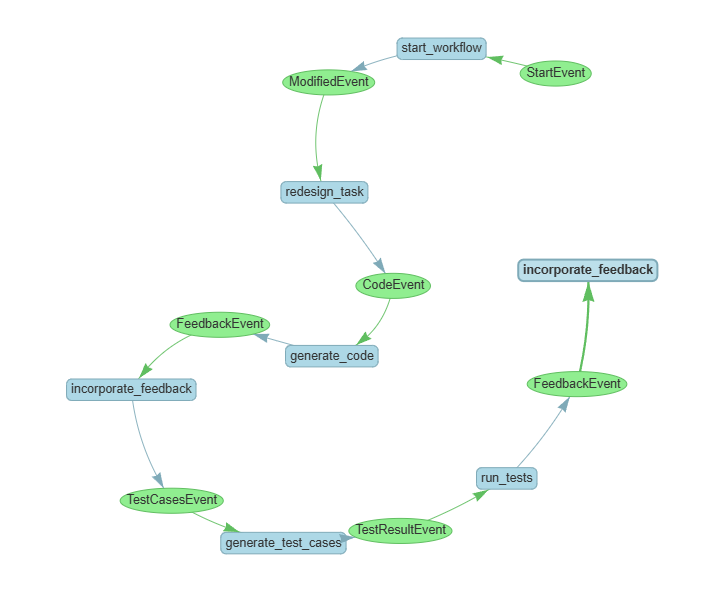

#### 2.

Lets explore a little more complex workflow with an even more complex task.

Lets say the task is to:

"Build a recommendation engine using machine learning that suggests products to users based on their previous browsing history"

We will explore a different workflow of CodeAssist:
- Provide the above task.
- Then ask to produce test cases for the given task.
- Then ask to run and test the generated code.
- The code runs perfectly and results in succesful termination. 

In [45]:
if __name__ == "__main__":
    groq_api_key = "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"
    task = input("Enter your programming task: ")
    
    r = CodingWorkflow(timeout= 300, verbose=True)
    result = await r.run(request = task)
    print(str(result))

Running step start_workflow
========= Original Task ===========
Task: Build a recommendation engine using machine learning that suggests products to users based on their previous browsing history,
Step start_workflow produced event ModifiedEvent
Running step redesign_task
========= Redesigned Task =========
Build a Product Recommendation Engine Using Machine Learning

**Primary Objective:**
Create a recommendation engine that suggests products to users based on their browsing history.

**Task Description:**
Develop a machine learning model that takes a user's browsing history as input and outputs a list of recommended products. The model should learn from the user's past interactions and adapt to their preferences over time.

**Input Requirements:**

* User browsing history (e.g., products viewed, searched, or purchased)
* Product catalog (e.g., product IDs, names, descriptions, categories)

**Output Requirements:**

* A list of recommended products for each user
* Optional: predicted 

In [46]:
draw_most_recent_execution(r, filename="trivial_workflow_execution.html")

trivial_workflow_execution.html


##### Visualise the workflow for the current demo.


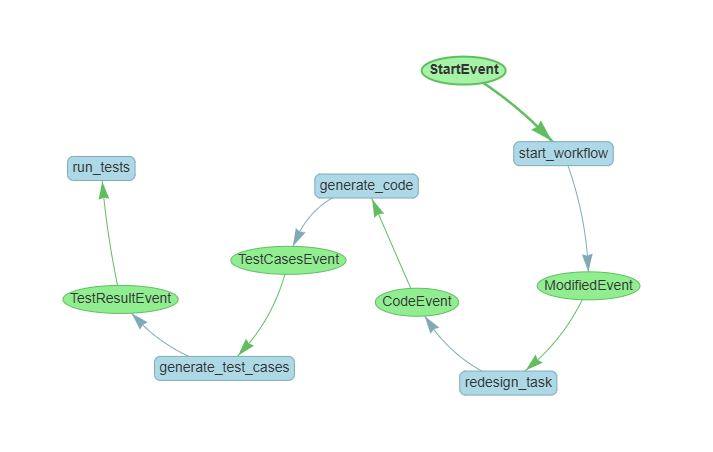

#### 3.

Lets say the task is to:

"Create a program that sorts a list of numbers in ascending order."

We will explore a looped workflow of CodeAssist:
- Provide the above task.
- go to feedback section to change the prompt to:
    - "Create a program that sorts a list of numbers in descending order."
- Then choose to give a new task.
    - "Print the log of the square of a number."
- Then stop the event. 

In [47]:
if __name__ == "__main__":
    groq_api_key = "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"
    task = input("Enter your programming task: ")
    
    p = CodingWorkflow(timeout= 300, verbose=True)
    result = await p.run(request = task)
    print(str(result))

Running step start_workflow
========= Original Task ===========
Task: Create a program that sorts a list of numbers in ascending order.
Step start_workflow produced event ModifiedEvent
Running step redesign_task
========= Redesigned Task =========
Create a program that sorts a list of numbers in ascending order. The input is a list of integers, and the output should be the same list sorted in ascending order. The program should be able to handle lists of varying lengths and should not modify the original list. The sorted list should be returned as output. Example input: [5, 2, 8, 1, 9], expected output: [1, 2, 5, 8, 9].
Step redesign_task produced event CodeEvent
Running step generate_code
========= Code Generation Response =========
# Approach: 
# Step 1: Define a function named 'solution' that takes a list of integers as input
# Step 2: Create a copy of the input list to avoid modifying the original list # this is to ensure the original list remains unchanged
# Step 3: Use the built-

In [48]:
draw_most_recent_execution(p, filename="trivial_workflow_execution.html")

trivial_workflow_execution.html


##### Look how CodeAssist loops back to ModifiedEvent():


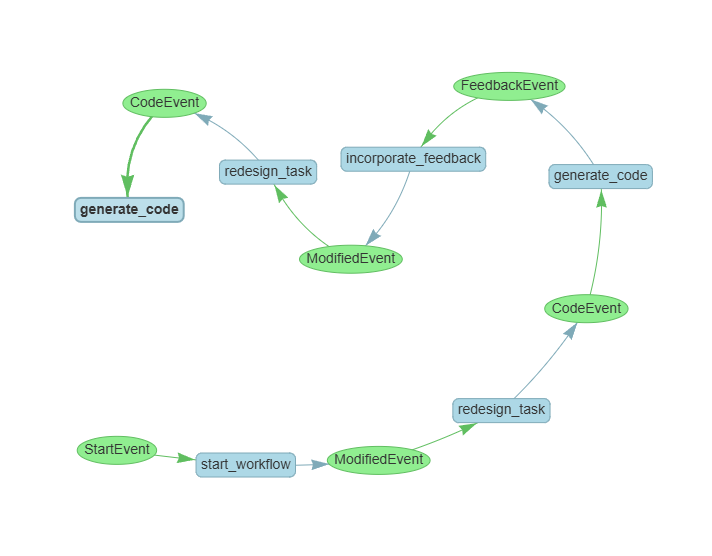